In [2]:
import os
from pathlib import Path

def root_dir(marker="EXPLib"):
    cwd = Path.cwd()
    # if cwd already contains the marker
    if (cwd / marker).is_dir():
        return cwd
    # otherwise walk up the parents
    for p in cwd.parents:
        if (p / marker).is_dir():
            return p
    raise FileNotFoundError(f"Root marker '{marker}' not found")

os.chdir(root_dir())
#print(os.getcwd())

In [2]:
from EXPLib.xai_library.data_explainers.prototypes.prototype_extractor_patch import run_analysis_pipeline

image_path    = './EXPLib/datasets/Camera/toy_model_v1_inference/examples_for_dataprototypes'
output_folder = './EXPLib/datasets/Camera/toy_model_v1_inference/prototypes'

Setting default gamma=0.001
Computing prototypes...Done.
[16, 64, 162, 243, 244, 259, 320, 354, 384, 410, 433, 499, 510, 568, 598, 629, 715, 734, 778, 806]


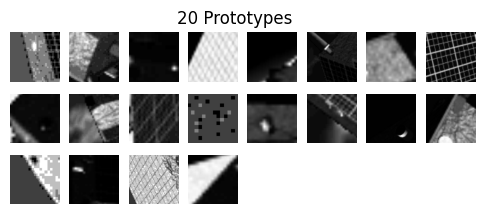

Computing criticisms...Done.
[44, 156, 254, 432, 540, 620, 647, 725, 771, 795]


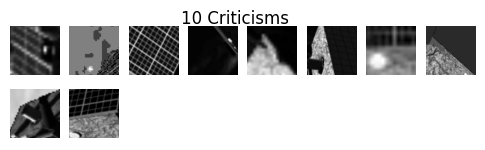

In [3]:
run_analysis_pipeline(image_path, output_folder, patch_size=100, num_criticisms=10, num_prototypes=20)

In [ ]:
from EXPLib.xai_library.data_explainers.data_descriptors import vae_descriptor
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define local dataset folder
dataset_folder = './EXPLib/datasets/Camera/toy_model_v1_inference/dev/images'
saved_model_folder = './EXPLib/dl_component/AEs/VAE/weight'
model_name = 'vae_model20240617_toy_dev_img.pth'
SAVED_MU_LATENT = './EXPLib/datasets/Camera/toy_model_v1_inference/vae_latents/mu_array_toydataset.npy'
test_img_folder = './EXPLib/datasets/Camera/toy_model_v1_inference/inference'
test_image='rgb_0000079_modified.png'
anotation_file = './EXPLib/datasets/Camera/toy_model_v1_inference/dev/satellite_objdet_coco_dataset.json'

resized_width = 160
resized_height = 160
latent_dim = 256
model_path = os.path.join(saved_model_folder, model_name)

vae_model = vae_descriptor.VAE(input_shape=(3, resized_height, resized_width), latent_dim=latent_dim).to(device)
vae_model = vae_descriptor.load_vae_model(vae_model, model_path, device)
mu_array = np.load(SAVED_MU_LATENT)
with open(anotation_file, "r") as f:
    toydataset_annotations = json.load(f)

Prototype 0:


c:\ProgramData\miniforge3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


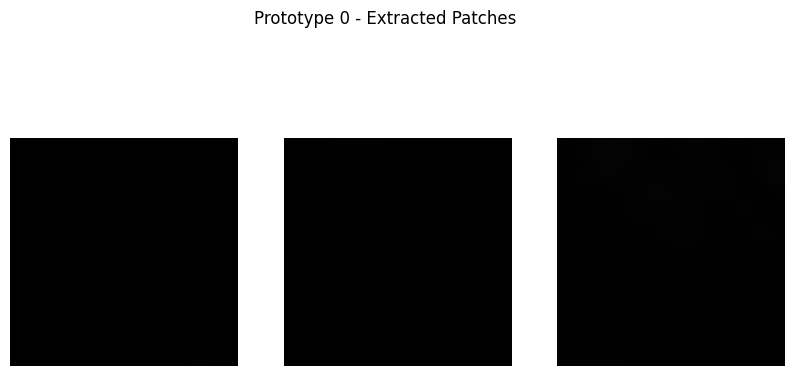

Prototype 1:


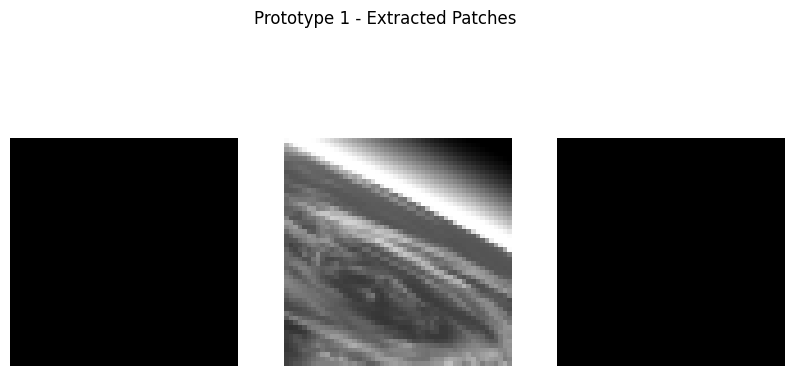

Prototype 2:


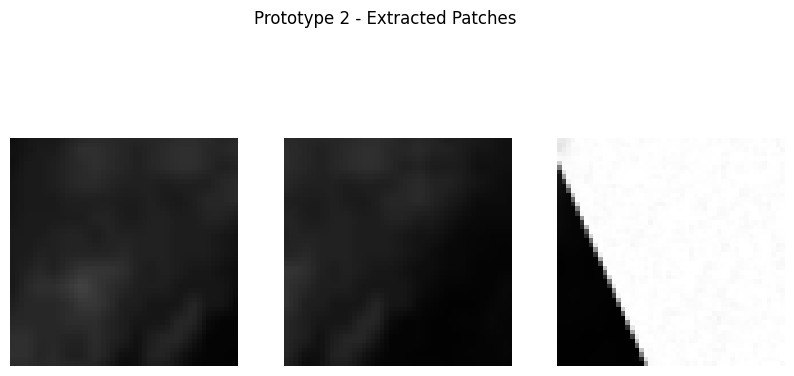

Prototype 3:


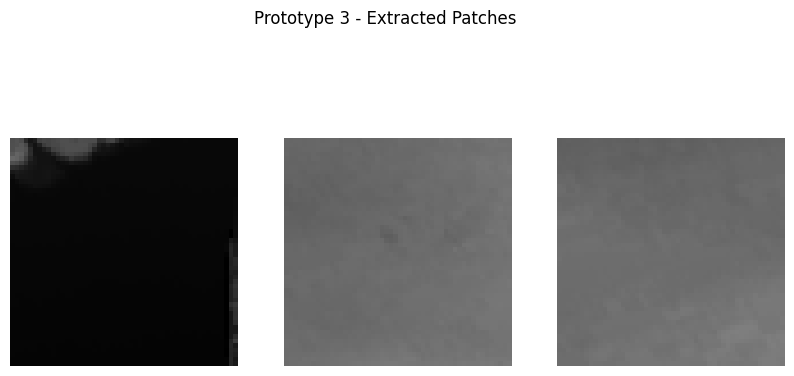

Prototype 4:


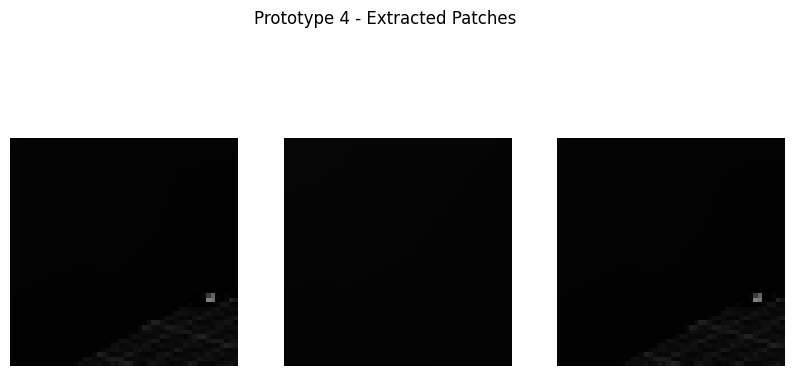

Prototype 5:


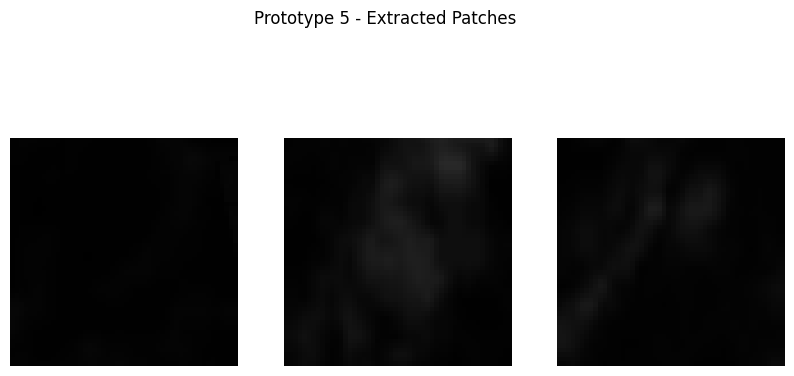

Prototype 6:


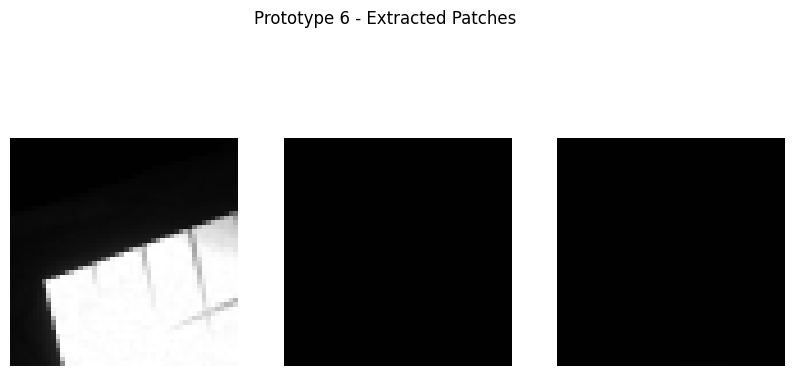

Prototype 7:


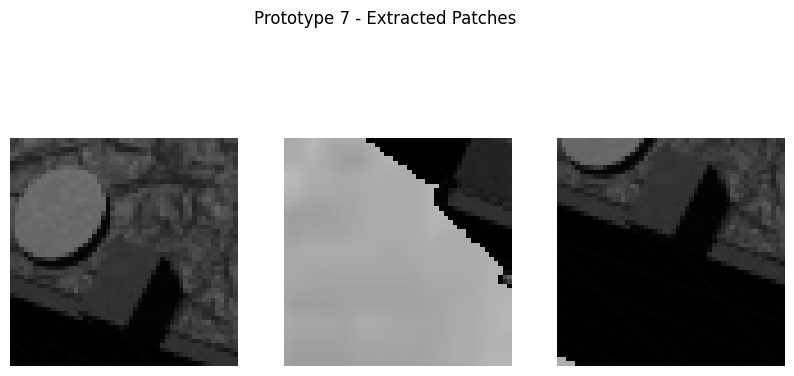

Prototype 8:


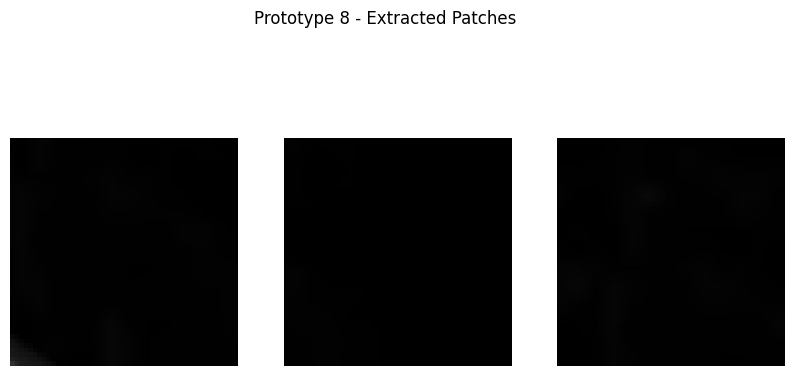

Prototype 9:


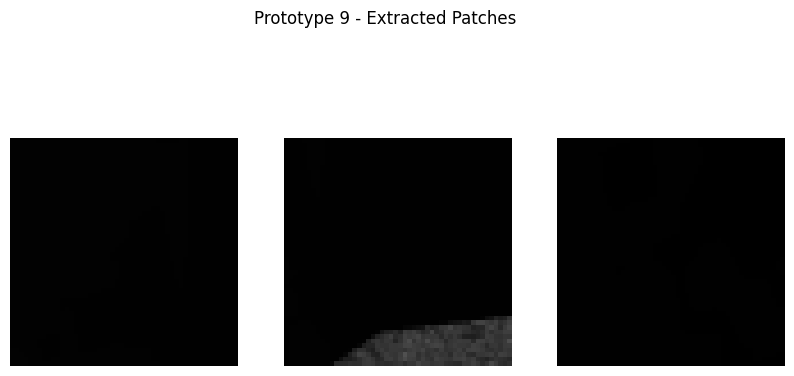

In [5]:
# Compute NMF prototypes
W, H = vae_descriptor.find_latent_prototypes(vae_descriptor.ensure_positive_latent(mu_array))


# ---- Compute Prototype Patches ----

patch_size_factor = 5  # Choose patch size factor: 1 for 10x10, 2 for 20x20, 3 for 30x30, etc.
activated_regions = vae_descriptor.find_activated_latent_regions(H, patch_size_factor=patch_size_factor)

for proto_idx, latent_coords in activated_regions.items():
    print(f"Prototype {proto_idx}:")
    
    # Map latent regions to image coordinates (find all matching patches)
    patch_positions = vae_descriptor.map_latent_to_image(latent_coords, image_size=160, feature_map_size=16, patch_size_factor=patch_size_factor)

    # Find best-matching image (search over all images, not just the same image)
    best_image_idx = np.argmax(W[:, proto_idx])  # Most representative image
    best_image_filename = vae_descriptor.find_image_filename(toydataset_annotations, best_image_idx)

    # Extract prototype patches
    patches = vae_descriptor.extract_prototype_patches(os.path.join(dataset_folder, best_image_filename), patch_positions, patch_size=10 * patch_size_factor)

    # Display patches
    fig, axes = plt.subplots(1, len(patches), figsize=(10, 5))
    for ax, patch in zip(axes, patches):
        ax.imshow(patch)
        ax.axis("off")
    plt.suptitle(f"Prototype {proto_idx} - Extracted Patches")
    plt.show()
